# Image Aberration Operations

## In this notebook I will illustrate the effect of different optical aberrations on an example image.

In [15]:
import WF_psf_mtf
from WF_psf_mtf import *
import pyfits
import numpy as np
import matplotlib.pyplot as plt

In [11]:
p = '/home/fatima/Desktop/solar_orbiter_project/codes/targets/MTF/'
data = pyfits.getdata(p+'Masi_hrt.fits')
data = data[300:600,0:300]

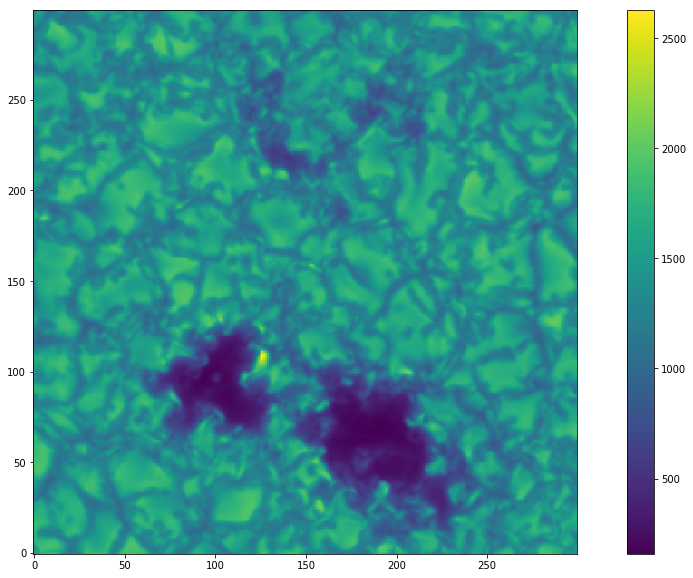

In [12]:
plt.figure(figsize=(18,10))
plt.imshow(data,origin='lower')
plt.colorbar()

## We will be working on a sub region of the whole image for computational purposes. 
### Declaring the telescope parameters again

In [27]:
D = 140 #diameter of the aperture
lam = 617.3*10**(-6) #wavelength of observation
pix = 0.5 #plate scale
f = 4125.3            #effective focal length      
size = data.shape[0] #size of detector in pixels


# Defocus
### I will show here how to introduce a defocus to the image using the wavefront aberration analysis described in <a href='https://github.com/fakahil/telescope-data-image-processing/blob/master/WF_psf_mtf.ipynb'> wavefront to PSF to MTF</a>. The defocus term is the fourth term in the Zernike expansion scheme. Usually the defocus is described in terms of optical path difference in terms of wavelength. So we will define a function that converts an OPD to a Zernike coefficient for

In [28]:
coefficients = np.zeros(8)
coefficients[0] = 0
coefficients[1] = 0
coefficients[2] = 0
coefficients[3] = 0.9
coefficients[4] = 0
coefficients[5] = 0
coefficients[6] = 0
coefficients[7] = 0

In [29]:
rpupil = pupil_size(D,lam,pix,size)
sim_phase = center(coefficients,size,rpupil)
Mask = mask(rpupil, size)


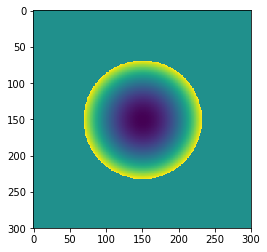

In [30]:
plt.imshow(sim_phase)

### you can see how the defocus aberration function is spehrically symmetric, which makes sense given that it depends on the radius not the azimuthal angle (in Geometric optics this translates to dependence on the distance from the optical axis, not the field angle)


## Let's construct now the corresponding PSF and OTF

In [31]:
pupil_com = complex_pupil(sim_phase,Mask)
psf = PSF(pupil_com)
otf = OTF(psf)
mtf = MTF(otf)

## Now we should convolved the simulation with the derived OTF. We multiply the FT of the image with the OTF, then use the inverse FT to derived the blurred image.

In [33]:
fft_image = np.fft.fft2(data)
temp = fft_image*otf
defoc = np.fft.ifft2(temp).real


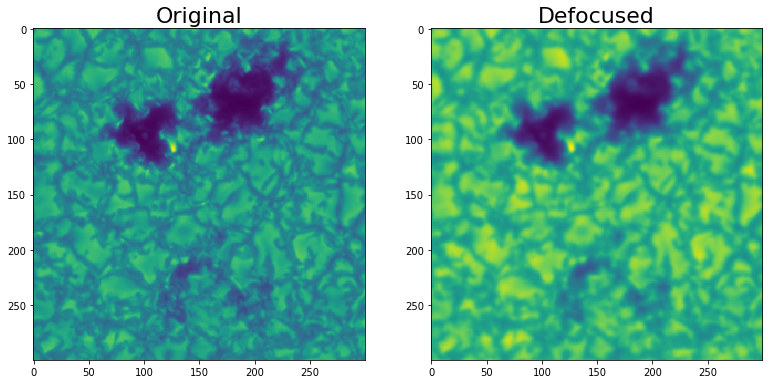

In [38]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121,aspect='equal')
ax2 = fig.add_subplot(122,aspect='equal')
im=ax.imshow(data)
im2=ax2.imshow(defoc)
fig.subplots_adjust(right=0.8)
ax.set_title('Original',fontsize=22)
ax2.set_title('Defocused',fontsize=22)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

# Image Misalignment

### Let's show here how to introduce image shifts to the original. This shift can be done by including the tip/tilt parameters (first 3 parameters), the OTF of which will result in geometrical translation in both x and y directions.

In [61]:
coefficients = np.zeros(8)
coefficients[0] = 0.5
coefficients[1] = 2
coefficients[2] = 21
coefficients[3] = 0
coefficients[4] = 0
coefficients[5] = 0
coefficients[6] = 0
coefficients[7] = 0

In [62]:
sim_phase = center(coefficients,size,rpupil)
pupil_com = complex_pupil(sim_phase,Mask)
psf = PSF(pupil_com)
otf = OTF(psf)
mtf = MTF(otf)

In [63]:
fft_image = np.fft.fft2(data)
temp = fft_image*otf
shifted = np.fft.ifft2(temp).real


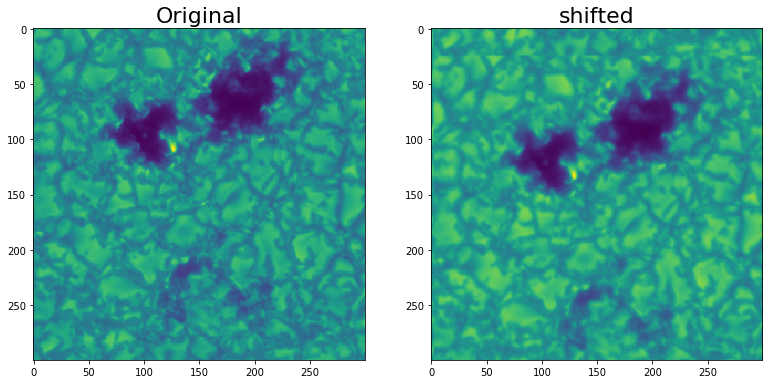

In [64]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121,aspect='equal')
ax2 = fig.add_subplot(122,aspect='equal')
im=ax.imshow(data)
im2=ax2.imshow(shifted)
fig.subplots_adjust(right=0.8)
ax.set_title('Original',fontsize=22)
ax2.set_title('shifted',fontsize=22)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)

## One can see that the shifted image is shifted more downward in the y direction. A better illustration would be to subtract the two images.

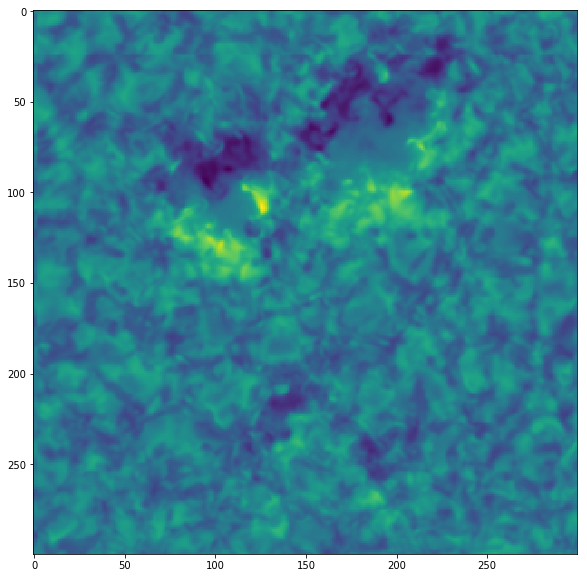

In [66]:
fig = plt.figure(figsize=(18,10))
plt.imshow(data-shifted)